# Setup

In [19]:
import os
import re
import json
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.constants import R_earth
import tensorflow as tf

from geexhp import datagen, datamod, datavis
from geexhp import stages as st_
from geexhp import datavis as dvis
dvis.configure_matplotlib()

In [2]:
# Load the dictionary containing the normalization statistics
with open('../data/normalization_stats.json', 'r') as f:
    stats = json.load(f)

# Load the best model
model_load = tf.keras.models.load_model("NN_22-tuner.keras")

In [3]:
# Denormalization functions for physical and chemical outputs
def denormalize_physical(predictions, stats, targets):
    original = np.zeros_like(predictions)
    for i, target in enumerate(targets):
        # Get stats: min, max, and best_n
        min_val = stats['outputs'][target]['min']
        max_val = stats['outputs'][target]['max']
        best_n = stats['outputs'][target]['best_n']
        # Inverse transformation:
        # prediction = ((val - min) / (max - min))^(1/best_n)
        # Thus, val = min + (max - min) * (prediction)^(best_n)
        original[:, i] = min_val + (max_val - min_val) * (predictions[:, i] ** best_n)
    return original

def denormalize_chemical(predictions, stats, targets):
    original = np.zeros_like(predictions)
    for i, target in enumerate(targets):
        best_n = stats['outputs'][target]['best_n']
        # Inverse transformation: prediction = val^(1/best_n) so val = prediction^(best_n)
        original[:, i] = predictions[:, i] ** best_n
    return original

In [4]:
# Target lists
physical_targets = [
    "OBJECT-RADIUS-REL-EARTH",
    "OBJECT-GRAVITY",
    "ATMOSPHERE-TEMPERATURE",
    "ATMOSPHERE-PRESSURE"
]
main_chemical_targets = ['O2', 'O3']
other_chemical_targets = ['CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O']

In [20]:
# Just for fun :3
def format_title_luvoir(file_name):
    base = file_name.replace('.npy', '')
    parts = base.split('_')

    if parts[-1].lower() == "luvoir":
        parts.pop()

    if len(parts) >= 2:
        era = parts[0]
        distance = parts[1]
    else:
        match = re.match(r"(.+?)(\d+pc)$", parts[0], flags=re.IGNORECASE)
        if match:
            era, distance = match.groups()
        else:
            era = parts[0]
            distance = ""

    era = era.capitalize().replace("without", " without ")
    distance = re.sub(r"(\d+)(pc)", r"\1 pc", distance, flags=re.IGNORECASE)

    if distance:
        title = f"{era} at {distance} - LUVOIR-B"
    else:
        title = f"{era} - LUVOIR-B"
        
    return title

def get_stage_from_filename(file_name):
    lower = file_name.lower()
    if "modern" in lower:
        return "modern"
    elif "proterozoic" in lower:
        return "proterozoic"
    elif "archean" in lower:
        return "archean"
    else:
        return "modern"

# LUVOIR-B

Processing file: proterozoic5pc_luvoir.npy


I0000 00:00:1741551817.899617   56370 service.cc:146] XLA service 0x784f040331f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741551817.899641   56370 service.cc:154]   StreamExecutor device (0): Host, Default Version
2025-03-09 17:23:37.912415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step

Physical Outputs Comparison:


I0000 00:00:1741551818.143675   56370 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.001951,0.998887,0.003064
1,OBJECT-GRAVITY,9.827499,9.807000,0.020499
2,ATMOSPHERE-TEMPERATURE,275.167480,289.000000,-13.832520
3,ATMOSPHERE-PRESSURE,1020.322205,959.000000,61.322205



Main Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,O2,4.381240e-03,2.629730e-03,1.751510e-03
1,O3,5.000000e-08,3.000000e-08,2.000000e-08



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,4.757910e-03,2.139460e-03,2.618450e-03
1,CO,3.144000e-05,1.741000e-05,1.402000e-05
2,CO2,3.704532e-02,1.252251e-02,2.452281e-02
3,H2O,8.890540e-03,4.682740e-03,4.207800e-03
4,N2,9.469361e-01,9.780081e-01,-3.107192e-02
5,N2O,1.000000e-08,1.000000e-08,1.000000e-08


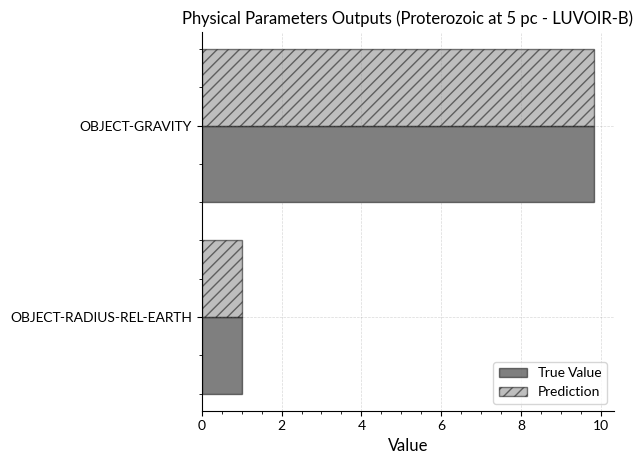

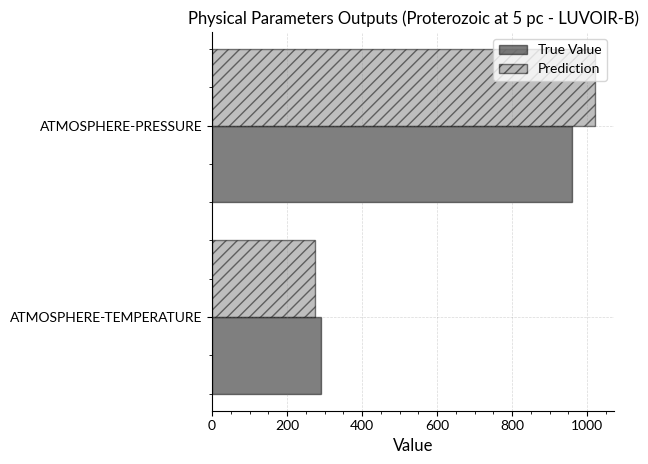

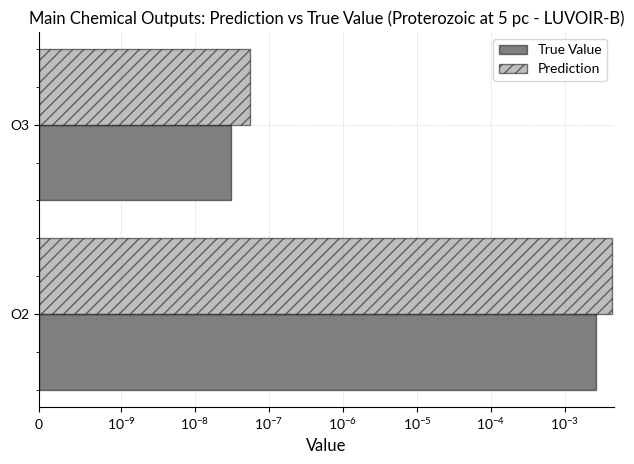

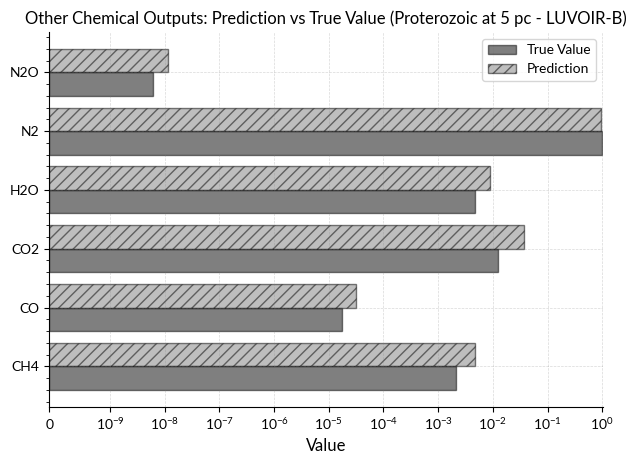



Processing file: modernwithoutO3_10pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.138275,0.998887,0.139388
1,OBJECT-GRAVITY,11.985320,9.807000,2.178319
2,ATMOSPHERE-TEMPERATURE,277.937836,288.200000,-10.262164
3,ATMOSPHERE-PRESSURE,1521.131226,1013.000000,508.131226



Main Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,O2,1.021512e-01,0.210931,-1.087800e-01
1,O3,1.000000e-08,0.000000,1.000000e-08



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,4.500000e-07,1.720000e-06,-1.260000e-06
1,CO,7.700000e-07,3.210000e-06,-2.440000e-06
2,CO2,4.078000e-05,3.830100e-04,-3.422300e-04
3,H2O,4.499000e-04,4.620700e-04,-1.216000e-05
4,N2,8.969948e-01,7.882168e-01,1.087780e-01
5,N2O,4.000000e-08,3.200000e-07,-2.800000e-07


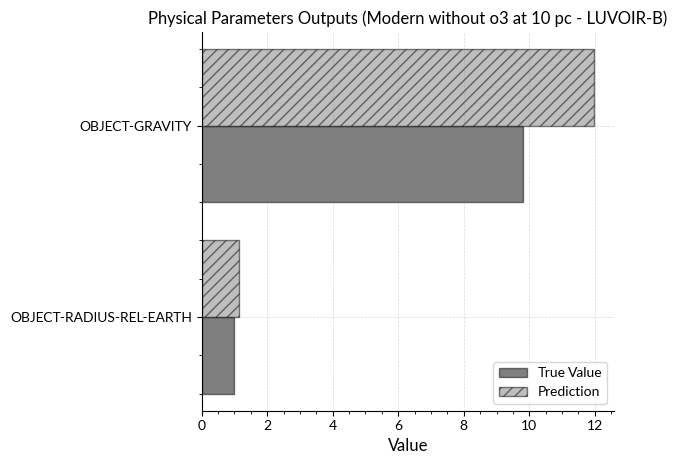

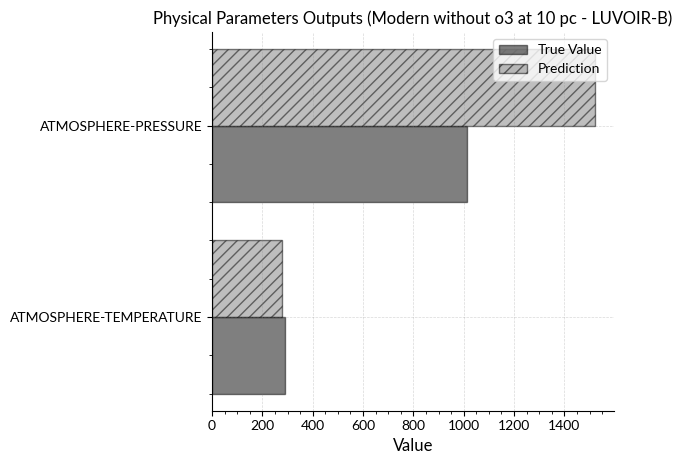

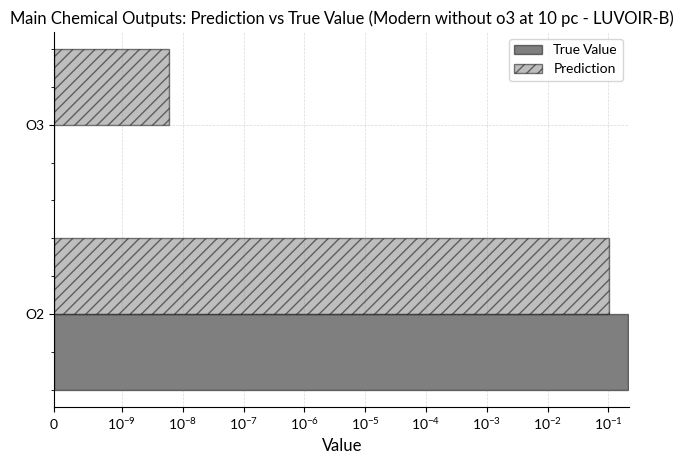

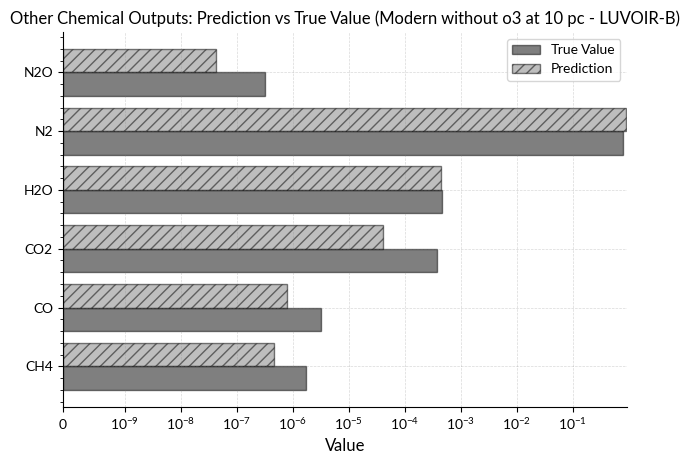



Processing file: archean5pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.211879,0.998887,0.212993
1,OBJECT-GRAVITY,13.433977,9.807000,3.626978
2,ATMOSPHERE-TEMPERATURE,274.037476,276.207386,-2.169911
3,ATMOSPHERE-PRESSURE,1911.778564,1000.000000,911.778442



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,0.001884,0.001927,-0.000043
1,CO,0.001557,0.001609,-0.000051
2,CO2,0.009249,0.012595,-0.003347
3,H2O,0.000114,0.000162,-0.000047
4,N2,0.982012,0.983706,-0.001694
5,N2O,0.000000,0.000000,0.000000


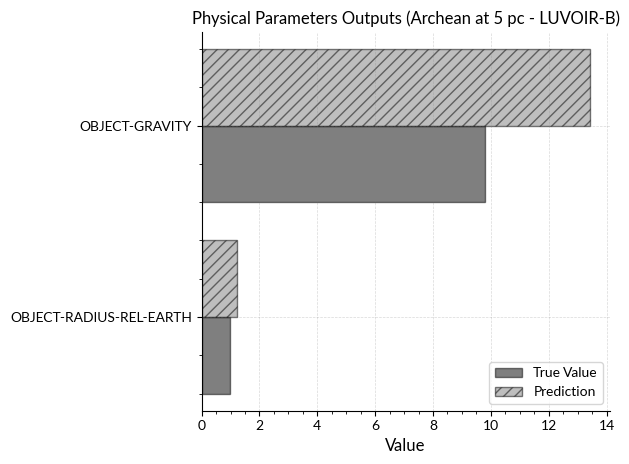

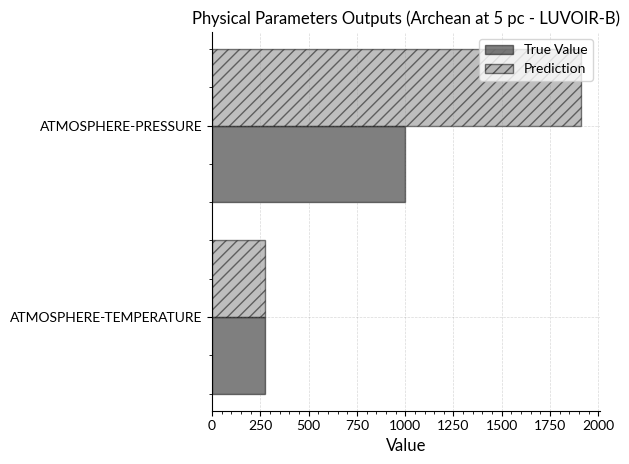

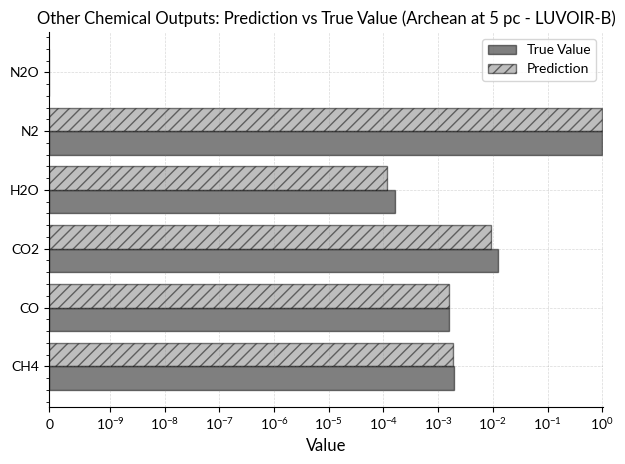



Processing file: archean10pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.173603,0.998887,0.174716
1,OBJECT-GRAVITY,12.683980,9.807000,2.876979
2,ATMOSPHERE-TEMPERATURE,273.931549,276.207386,-2.275837
3,ATMOSPHERE-PRESSURE,1705.360474,1000.000000,705.360474



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,0.002310,0.001927,0.000383
1,CO,0.001903,0.001609,0.000295
2,CO2,0.015692,0.012595,0.003097
3,H2O,0.000144,0.000162,-0.000018
4,N2,0.968605,0.983706,-0.015101
5,N2O,0.000000,0.000000,0.000000


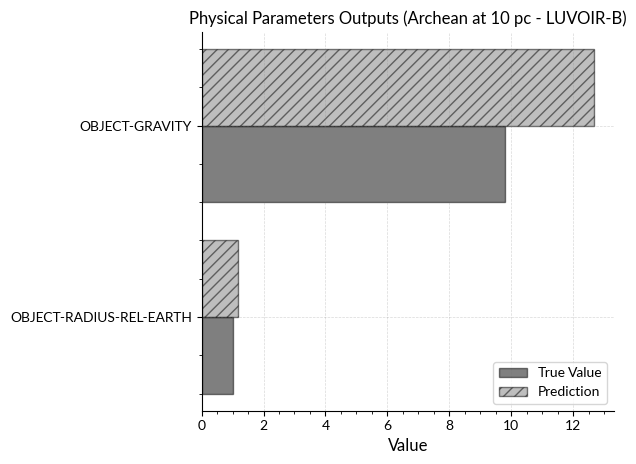

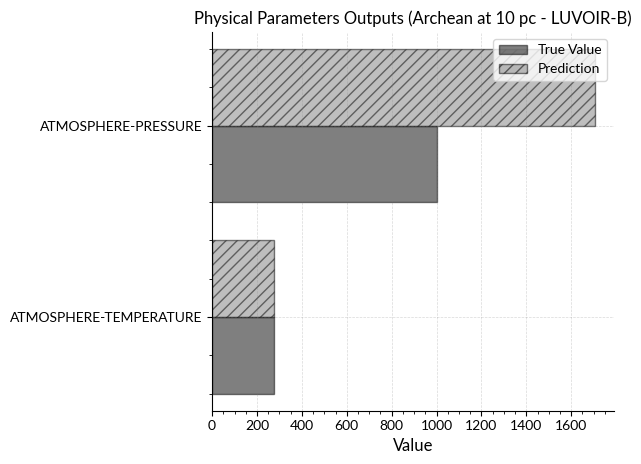

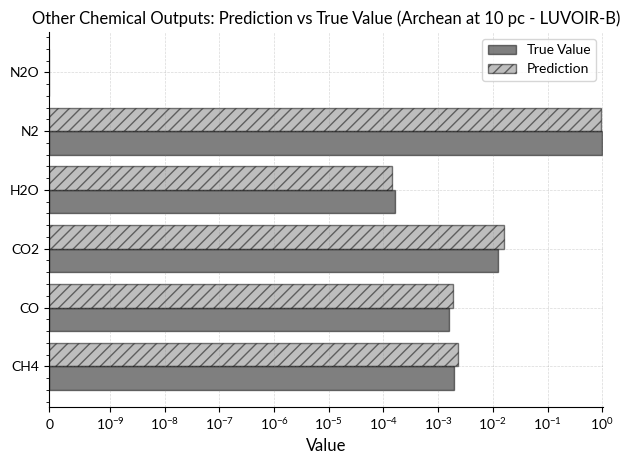



Processing file: archean15pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.184689,0.998887,0.185802
1,OBJECT-GRAVITY,12.847665,9.807000,3.040665
2,ATMOSPHERE-TEMPERATURE,310.854248,276.207386,34.646862
3,ATMOSPHERE-PRESSURE,1747.095215,1000.000000,747.095215



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,0.004022,0.001927,0.002095
1,CO,0.002055,0.001609,0.000446
2,CO2,0.033424,0.012595,0.020828
3,H2O,0.000271,0.000162,0.000109
4,N2,0.948737,0.983706,-0.034969
5,N2O,0.000000,0.000000,0.000000


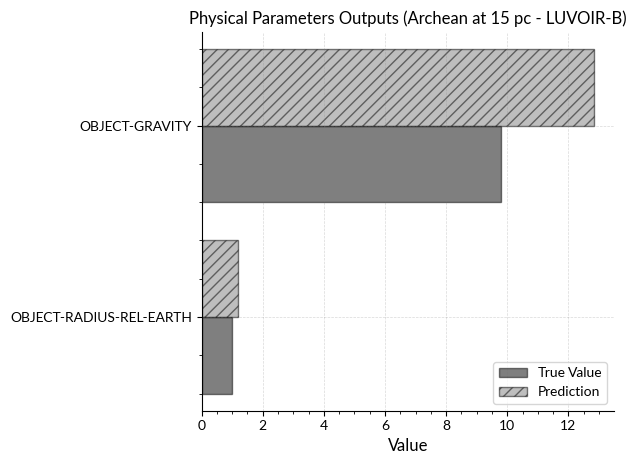

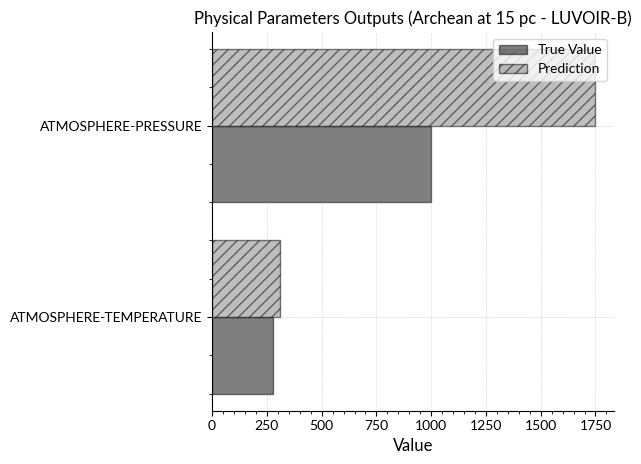

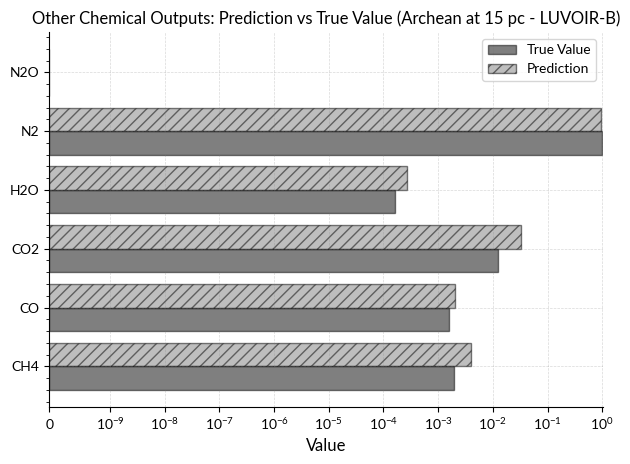



Processing file: modern15pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.168293,0.998887,0.169406
1,OBJECT-GRAVITY,12.529826,9.807000,2.722826
2,ATMOSPHERE-TEMPERATURE,283.277130,288.200000,-4.922870
3,ATMOSPHERE-PRESSURE,1661.438965,1013.000000,648.439087



Main Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,O2,0.151605,0.210931,-0.059326
1,O3,0.000003,0.000002,0.000002



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,2.220000e-06,1.720000e-06,5.000000e-07
1,CO,4.110000e-06,3.210000e-06,9.000000e-07
2,CO2,5.081400e-04,3.830100e-04,1.251400e-04
3,H2O,4.115000e-04,4.620700e-04,-5.057000e-05
4,N2,8.399815e-01,7.882168e-01,5.176474e-02
5,N2O,2.700000e-07,3.200000e-07,-5.000000e-08


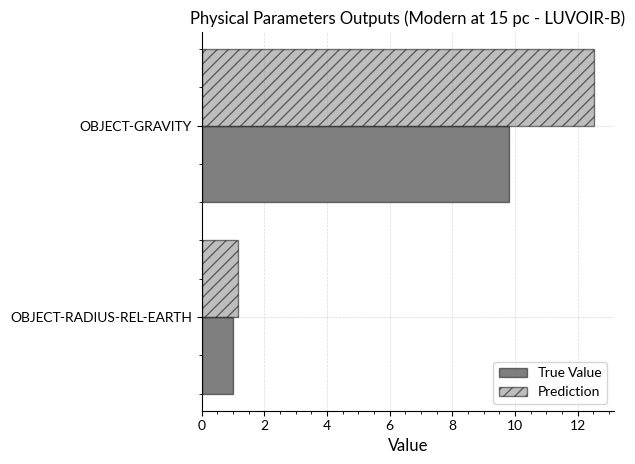

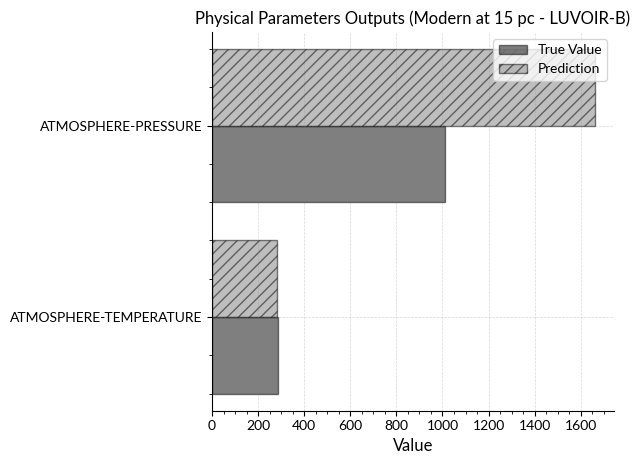

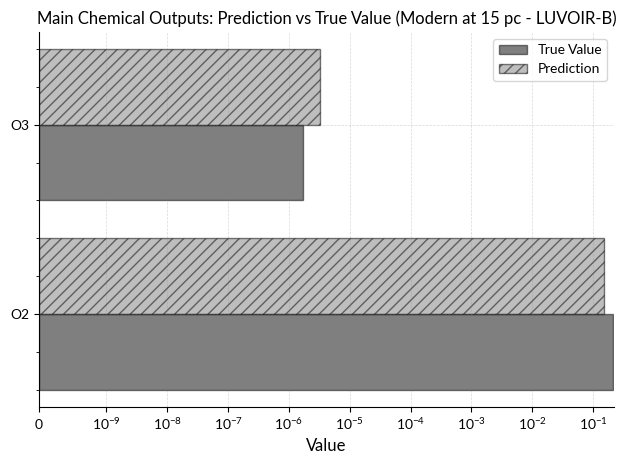

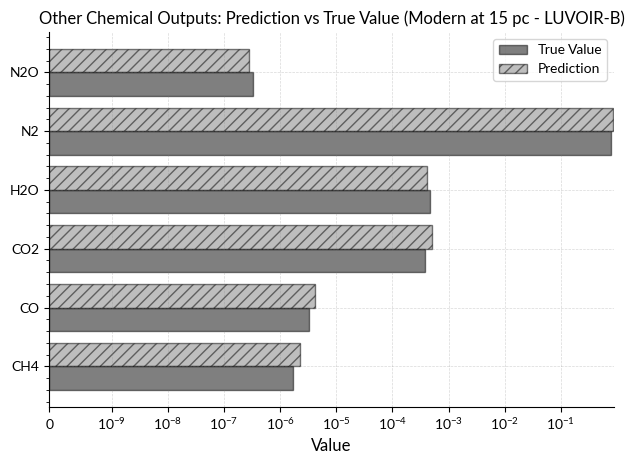



Processing file: modern10pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.107567,0.998887,0.108680
1,OBJECT-GRAVITY,11.483265,9.807000,1.676265
2,ATMOSPHERE-TEMPERATURE,276.772308,288.200000,-11.427692
3,ATMOSPHERE-PRESSURE,1391.361938,1013.000000,378.361938



Main Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,O2,0.288520,0.210931,0.077589
1,O3,0.000003,0.000002,0.000002



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,1.220000e-06,1.720000e-06,-4.900000e-07
1,CO,2.040000e-06,3.210000e-06,-1.170000e-06
2,CO2,5.998000e-05,3.830100e-04,-3.230300e-04
3,H2O,4.922100e-04,4.620700e-04,3.015000e-05
4,N2,7.080824e-01,7.882168e-01,-8.013438e-02
5,N2O,2.600000e-07,3.200000e-07,-7.000000e-08


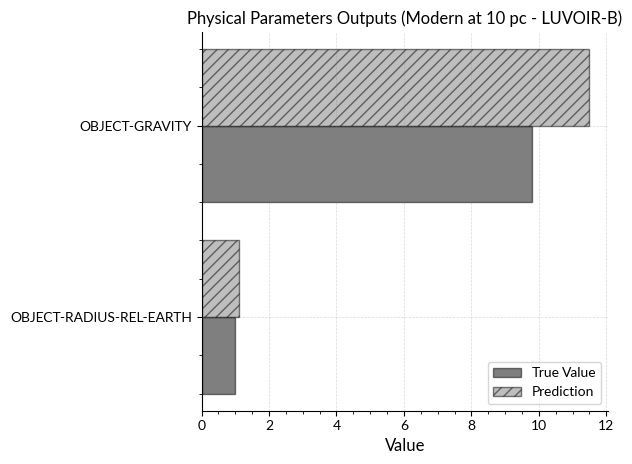

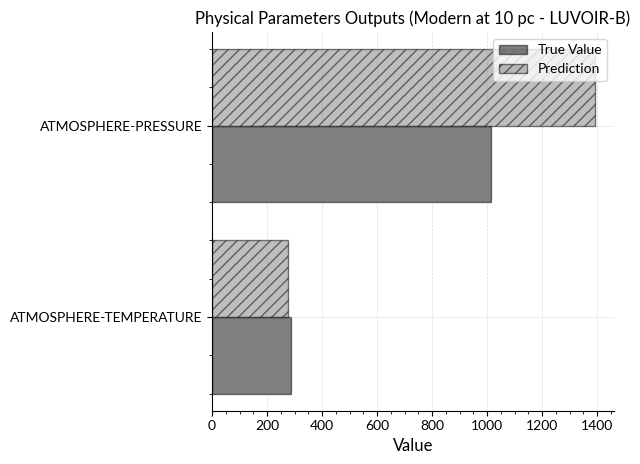

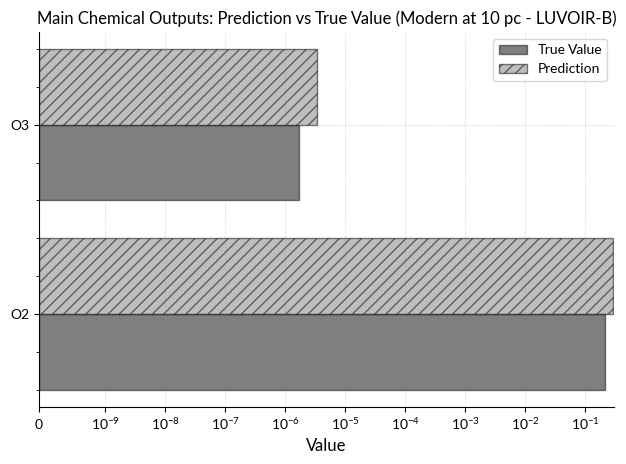

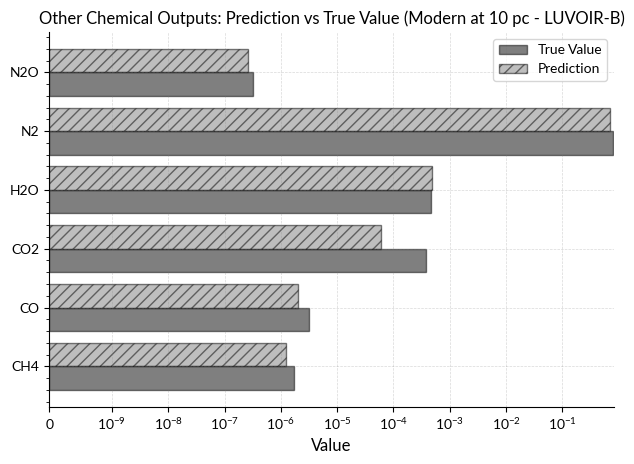



Processing file: proterozoic10pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.000103,0.998887,0.001216
1,OBJECT-GRAVITY,9.792897,9.807000,-0.014103
2,ATMOSPHERE-TEMPERATURE,276.631287,289.000000,-12.368713
3,ATMOSPHERE-PRESSURE,1013.005737,959.000000,54.005798



Main Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,O2,7.358300e-03,2.629730e-03,4.728580e-03
1,O3,6.000000e-08,3.000000e-08,3.000000e-08



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,5.449230e-03,2.139460e-03,3.309770e-03
1,CO,4.264000e-05,1.741000e-05,2.522000e-05
2,CO2,7.111274e-02,1.252251e-02,5.859023e-02
3,H2O,9.772760e-03,4.682740e-03,5.090020e-03
4,N2,9.048137e-01,9.780081e-01,-7.319446e-02
5,N2O,2.000000e-08,1.000000e-08,1.000000e-08


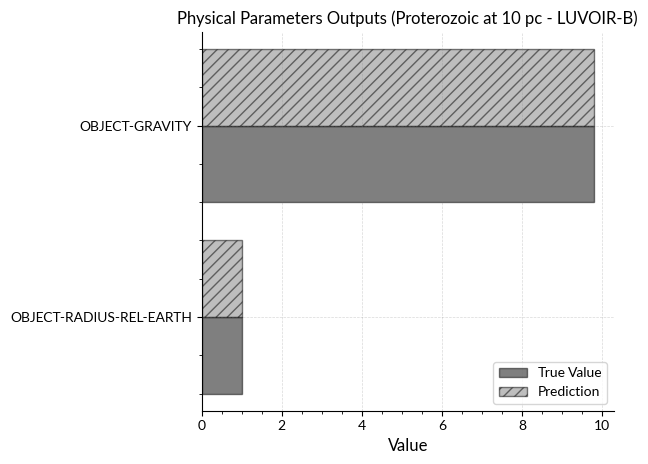

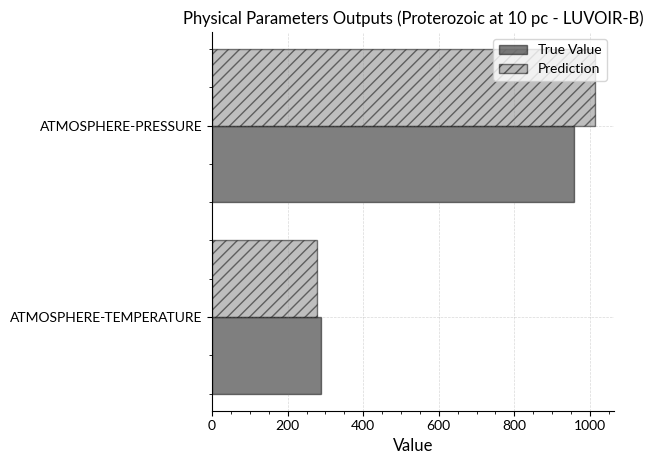

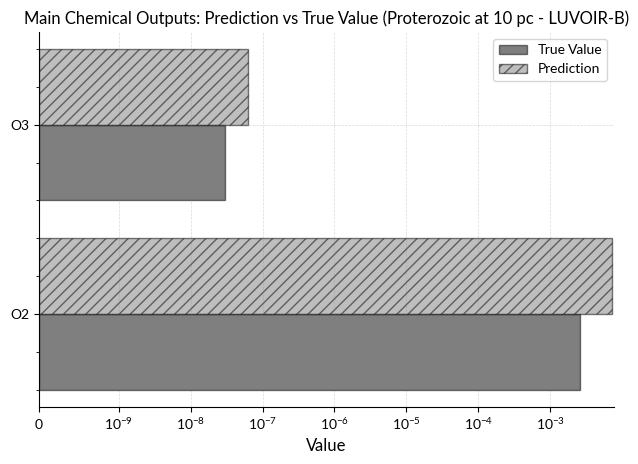

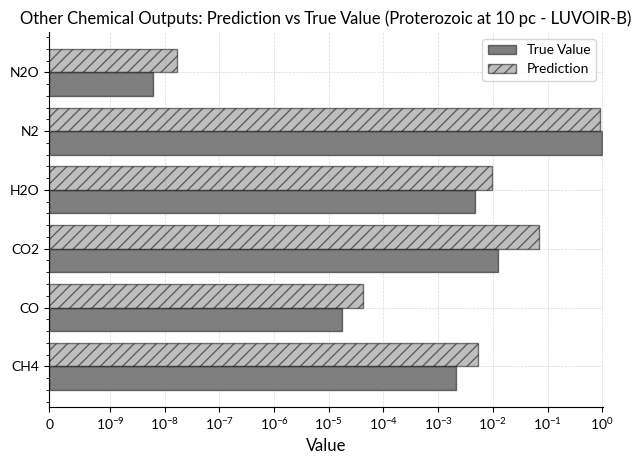



Processing file: modernwithoutO2_10pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.082087,0.998887,0.083200
1,OBJECT-GRAVITY,10.977642,9.807000,1.170642
2,ATMOSPHERE-TEMPERATURE,279.734406,288.200000,-8.465594
3,ATMOSPHERE-PRESSURE,1276.245850,1013.000000,263.245850



Main Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,O2,0.003947,0.000000,0.003947
1,O3,0.000004,0.000002,0.000002



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,2.500000e-07,1.720000e-06,-1.460000e-06
1,CO,1.010000e-06,3.210000e-06,-2.200000e-06
2,CO2,9.871000e-05,3.830100e-04,-2.843000e-04
3,H2O,5.853400e-04,4.620700e-04,1.232800e-04
4,N2,1.000000e+00,7.882168e-01,2.117832e-01
5,N2O,8.000000e-08,3.200000e-07,-2.400000e-07


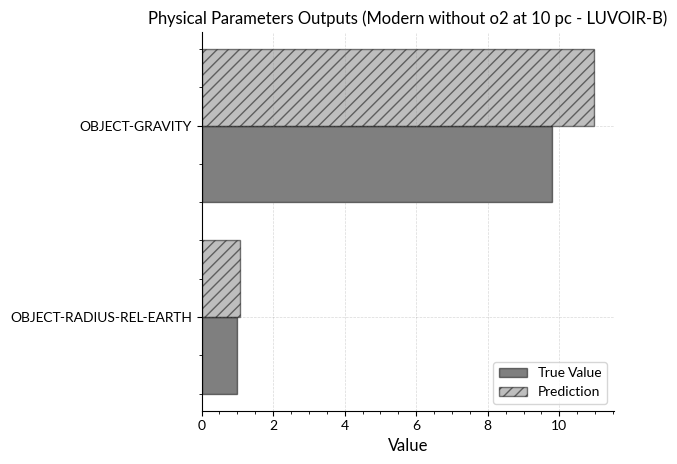

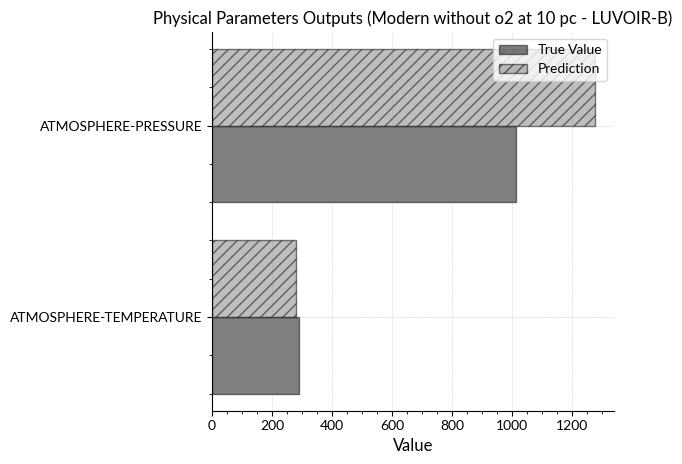

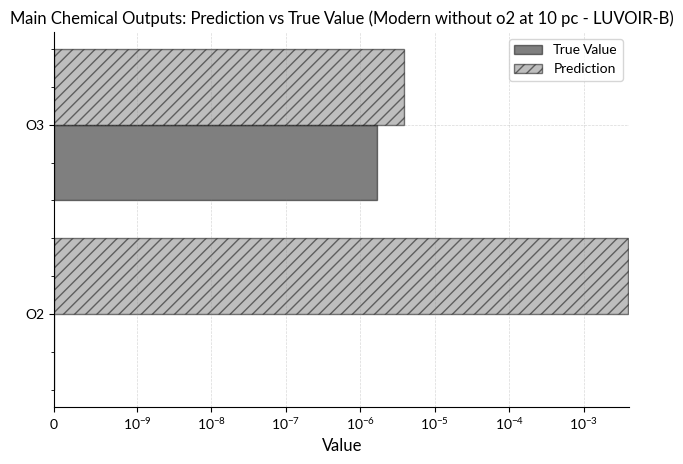

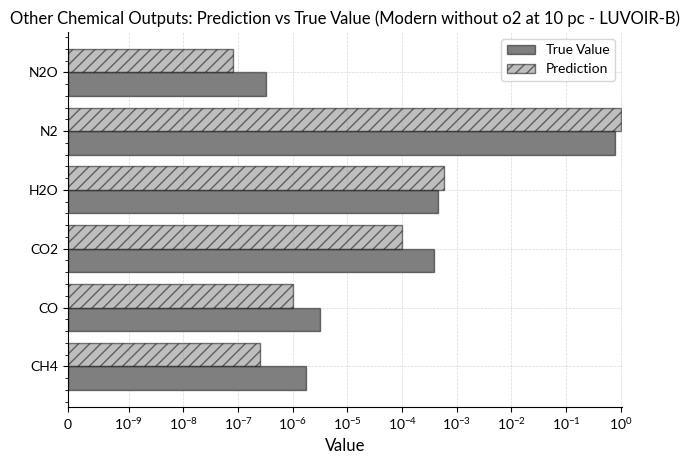



Processing file: proterozoic15pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.112107,0.998887,0.113220
1,OBJECT-GRAVITY,11.571060,9.807000,1.764060
2,ATMOSPHERE-TEMPERATURE,288.807617,289.000000,-0.192383
3,ATMOSPHERE-PRESSURE,1410.286255,959.000000,451.286255



Main Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,O2,5.049500e-03,2.629730e-03,2.419770e-03
1,O3,4.000000e-08,3.000000e-08,1.000000e-08



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,3.827760e-03,2.139460e-03,0.001688
1,CO,2.223000e-05,1.741000e-05,0.000005
2,CO2,1.876323e-02,1.252251e-02,0.006241
3,H2O,6.238560e-03,4.682740e-03,0.001556
4,N2,9.588212e-01,9.780081e-01,-0.019187
5,N2O,1.000000e-08,1.000000e-08,0.000000


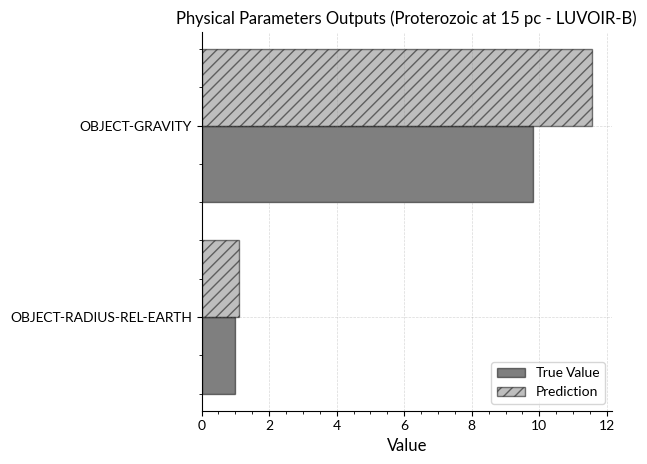

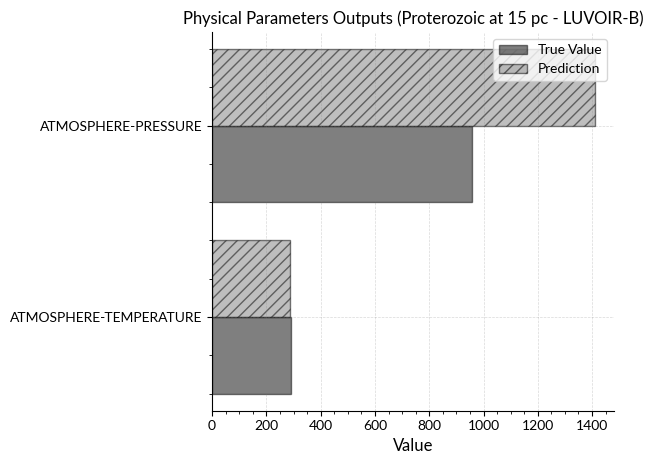

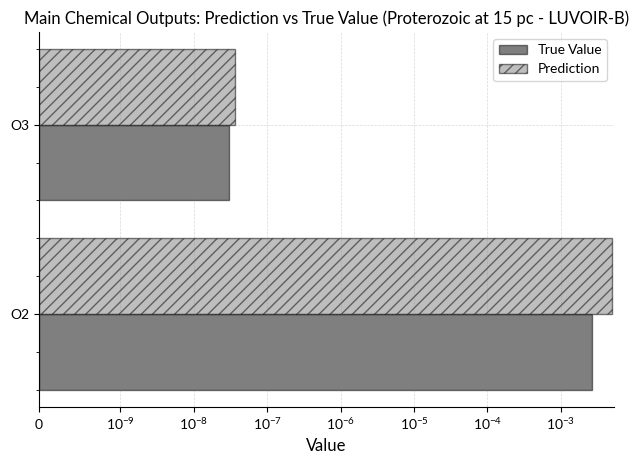

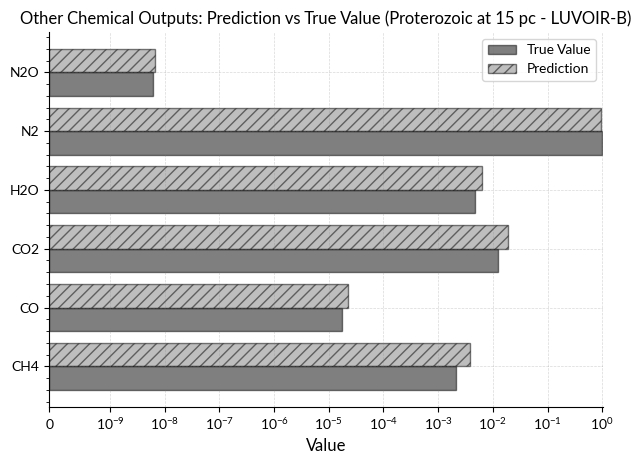



Processing file: modern5pc_luvoir.npy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Physical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,OBJECT-RADIUS-REL-EARTH,1.172698,0.998887,0.173812
1,OBJECT-GRAVITY,12.629359,9.807000,2.822359
2,ATMOSPHERE-TEMPERATURE,276.508972,288.200000,-11.691028
3,ATMOSPHERE-PRESSURE,1688.783081,1013.000000,675.783081



Main Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,O2,0.152247,0.210931,-5.868399e-02
1,O3,0.000003,0.000002,9.500000e-07



Other Chemical Outputs Comparison:


,Target,Prediction,True Value,Difference
0,CH4,8.700000e-07,1.720000e-06,-8.400000e-07
1,CO,2.390000e-06,3.210000e-06,-8.200000e-07
2,CO2,3.317800e-04,3.830100e-04,-5.122000e-05
3,H2O,3.510600e-04,4.620700e-04,-1.110000e-04
4,N2,8.337335e-01,7.882168e-01,4.551680e-02
5,N2O,2.700000e-07,3.200000e-07,-6.000000e-08


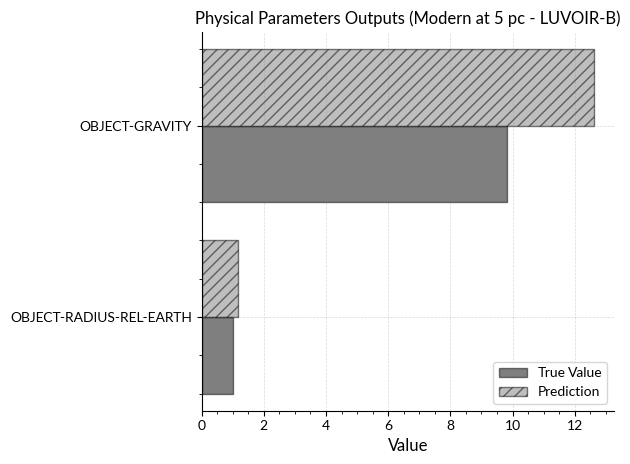

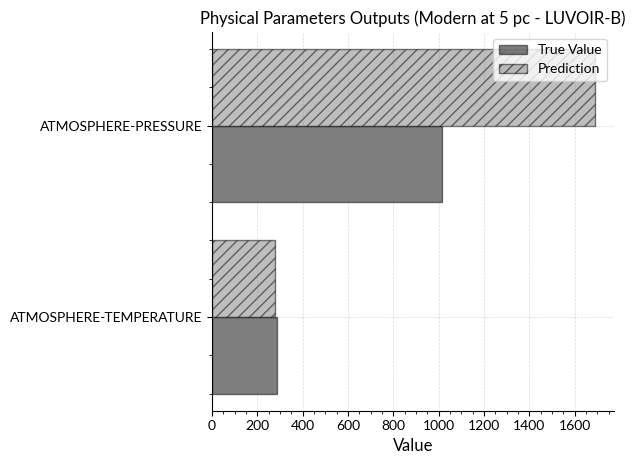

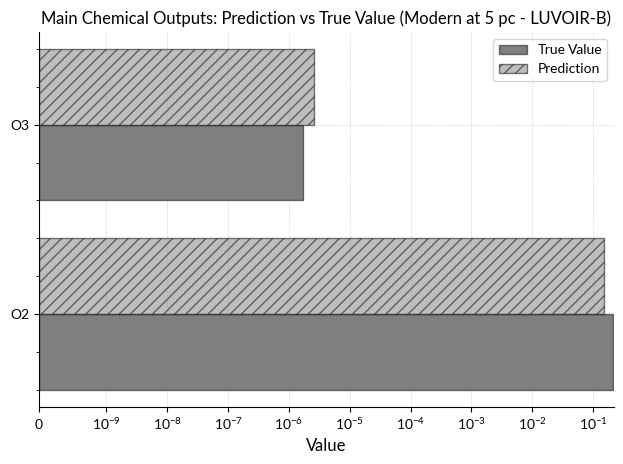

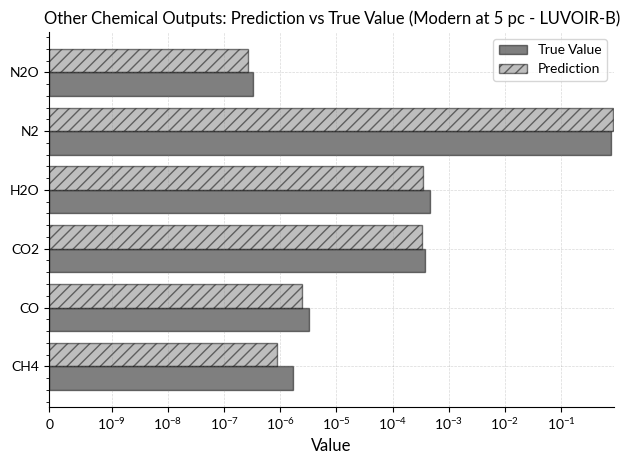

In [6]:
npy_files = glob.glob("../data/tests/*luvoir*.npy")

for file_path in npy_files:
    ############ DATA PROCESSING ############
    file_name = os.path.basename(file_path)
    formatted_title = format_title_luvoir(file_name)
    print(f"Processing file: {file_name}")
    
    data = np.load(file_path, allow_pickle=True)
    
    uv = data[0]["NOISY_ALBEDO"]
    vis = data[1]["NOISY_ALBEDO"]
    nir = data[2]["NOISY_ALBEDO"]
    
    uv_mean, uv_std = stats['inputs']['B-UV']['mean'], stats['inputs']['B-UV']['std']
    vis_mean, vis_std = stats['inputs']['B-Vis']['mean'], stats['inputs']['B-Vis']['std']
    nir_mean, nir_std = stats['inputs']['B-NIR']['mean'], stats['inputs']['B-NIR']['std']

    ############ DENORMALIZATION ############
    uv_normalized = (uv - uv_mean) / uv_std
    vis_normalized = (vis - vis_mean) / vis_std
    nir_normalized = (nir - nir_mean) / nir_std

    uv_normalized = uv_normalized.reshape(1, 8, 1)
    vis_normalized = vis_normalized.reshape(1, 94, 1)
    nir_normalized = nir_normalized.reshape(1, 49, 1)
    
    predictions = model_load.predict([uv_normalized, vis_normalized, nir_normalized])
    
    physical_pred = denormalize_physical(predictions['physical_output'], stats, physical_targets)
    main_chem_pred = denormalize_chemical(predictions['main_chemical_output'], stats, main_chemical_targets)
    other_chem_pred = denormalize_chemical(predictions['other_chemical_output'], stats, other_chemical_targets)
    
    ############ COMPARISON TABLES ############
    def get_gt(target):
        val = data[0].get(target, None)
        if val is None:
            return 0.0
        try:
            return float(val)
        except (ValueError, TypeError):
            return 0.0

    def build_comparison_df(targets, pred_values):
        data_list = []
        for i, target in enumerate(targets):
            pred_val = pred_values[0][i]
            gt_val = get_gt(target)
            diff = pred_val - gt_val
            data_list.append({
                "Target": target,
                "Prediction": pred_val,
                "True Value": gt_val,
                "Difference": diff
            })
        return pd.DataFrame(data_list)

    physical_df = build_comparison_df(physical_targets, physical_pred)
    main_chem_df = build_comparison_df(main_chemical_targets, main_chem_pred)
    other_chem_df = build_comparison_df(other_chemical_targets, other_chem_pred)
    
    print("\nPhysical Outputs Comparison:")
    display(physical_df.round(8))
    
    if 'archean' not in file_name.lower():
        print("\nMain Chemical Outputs Comparison:")
        display(main_chem_df.round(8))
    
    print("\nOther Chemical Outputs Comparison:")
    display(other_chem_df.round(8))

    ############ PLOTTING ############
    low_physical_targets = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY"]
    high_physical_targets = ["ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
    
    low_physical_df = physical_df[physical_df["Target"].isin(low_physical_targets)]
    high_physical_df = physical_df[physical_df["Target"].isin(high_physical_targets)]
    
    if not low_physical_df.empty:
        y_low = range(len(low_physical_df))
        plt.barh(y_low, low_physical_df["True Value"], height=0.4, label="True Value",
                    color='black', alpha=0.5, edgecolor='black')
        plt.barh([i + 0.4 for i in y_low], low_physical_df["Prediction"], height=0.4, label="Prediction",
                    color='tab:gray', alpha=0.5, edgecolor='black', hatch='///')
        plt.yticks([i + 0.2 for i in y_low], low_physical_df["Target"])
        plt.xlabel("Value")
        plt.title(f"Physical Parameters Outputs ({formatted_title})")
        plt.legend()
        plt.tight_layout()
        plt.show()

    if not high_physical_df.empty:
        y_high = range(len(high_physical_df))
        plt.barh(y_high, high_physical_df["True Value"], height=0.4, label="True Value",
                    color='black', alpha=0.5, edgecolor='black')
        plt.barh([i + 0.4 for i in y_high], high_physical_df["Prediction"], height=0.4, label="Prediction",
                    color='tab:gray', alpha=0.5, edgecolor='black', hatch='///')
        plt.yticks([i + 0.2 for i in y_high], high_physical_df["Target"])
        plt.xlabel("Value")
        plt.title(f"Physical Parameters Outputs ({formatted_title})")
        plt.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

    if 'archean' not in file_name.lower():
        y_main = range(len(main_chem_df))
        plt.barh(y_main, main_chem_df["True Value"], height=0.4, label="True Value",
                    color='black', alpha=0.5, edgecolor='black')
        plt.barh([i + 0.4 for i in y_main], main_chem_df["Prediction"], height=0.4, label="Prediction",
                    color='tab:gray', alpha=0.5, edgecolor='black', hatch='///')
        plt.yticks([i + 0.2 for i in y_main], main_chem_df["Target"])
        plt.xlabel("Value")
        plt.title(f"Main Chemical Outputs: Prediction vs True Value ({formatted_title})")
        plt.legend(loc="upper right")
        plt.xscale('symlog', linthresh=1e-9)
        plt.tight_layout()
        plt.show()

    y_other = range(len(other_chem_df))
    plt.barh(y_other, other_chem_df["True Value"], height=0.4, label="True Value",
                color='black', alpha=0.5, edgecolor='black')
    plt.barh([i + 0.4 for i in y_other], other_chem_df["Prediction"], height=0.4, label="Prediction",
                color='tab:gray', alpha=0.5, edgecolor='black', hatch='///')
    plt.yticks([i + 0.2 for i in y_other], other_chem_df["Target"])
    plt.xlabel("Value")
    plt.title(f"Other Chemical Outputs: Prediction vs True Value ({formatted_title})")
    plt.legend(loc="upper right")
    plt.xscale('symlog', linthresh=1e-9)
    plt.tight_layout()
    plt.show()

    print("\n" + "="*100 + "\n")

# Recover the spectrum

In [11]:
def get_config_data(stage="modern"):
    dg = datagen.DataGen(stage=stage)
    config_str = dg.config_str
    config_dict = dg._parse_config(config_str)
    datamod.mixing_ratio_constant(config_dict, 60)
    datamod.normalize_layer(config_dict, 60, st_.molweightlist(era=stage))
    return dg, config_dict

In [ ]:
def generate_original_spectrum(config, instrument, dg):
    config_serialized = dg._serialize_config(config)
    wavelength, total, noise, _ = dg._generate_spectrum_for_instrument(config_serialized, instrument)
    noisy_albedo = np.random.normal(loc=total, scale=noise)
    df = pd.DataFrame({
        "WAVELENGTH": wavelength,
        "ALBEDO": total,
        "NOISE": noise,
        "NOISY_ALBEDO": noisy_albedo
    })
    return df

In [21]:
def generate_modified_spectrum(config, instrument, dg, radius, gravity, temperature, pressure, gas_values):
    modified_config = config.copy()

    modified_config['OBJECT-DIAMETER'] = radius * (2 * R_earth.to("km").value)
    modified_config['OBJECT-GRAVITY'] = gravity
    modified_config['ATMOSPHERE-TEMPERATURE'] = temperature
    modified_config['ATMOSPHERE-PRESSURE'] = pressure

    elements = modified_config.get("ATMOSPHERE-LAYERS-MOLECULES", "").split(",")
    
    # Update each gas in the provided gas_values dictionary
    for gas, new_value in gas_values.items():
        if gas in elements:
            gas_index = elements.index(gas)
            for key, value in modified_config.items():
                if key.startswith("ATMOSPHERE-LAYER-"):
                    values = value.split(',')
                    values[gas_index + 2] = str(new_value)
                    modified_config[key] = ','.join(values)

    config_serialized = dg._serialize_config(modified_config)
    wavelength, total, noise, _ = dg._generate_spectrum_for_instrument(config_serialized, instrument)
    noisy_albedo = np.random.normal(loc=total, scale=noise)
    df = pd.DataFrame({
        "WAVELENGTH": wavelength,
        "ALBEDO": total,
        "NOISE": noise,
        "NOISY_ALBEDO": noisy_albedo
    })
    return df

Processing: Archean at 10 pc - LUVOIR-B with stage: archean
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


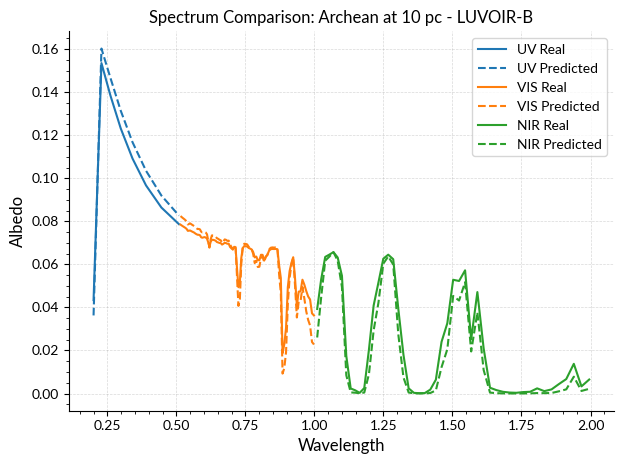

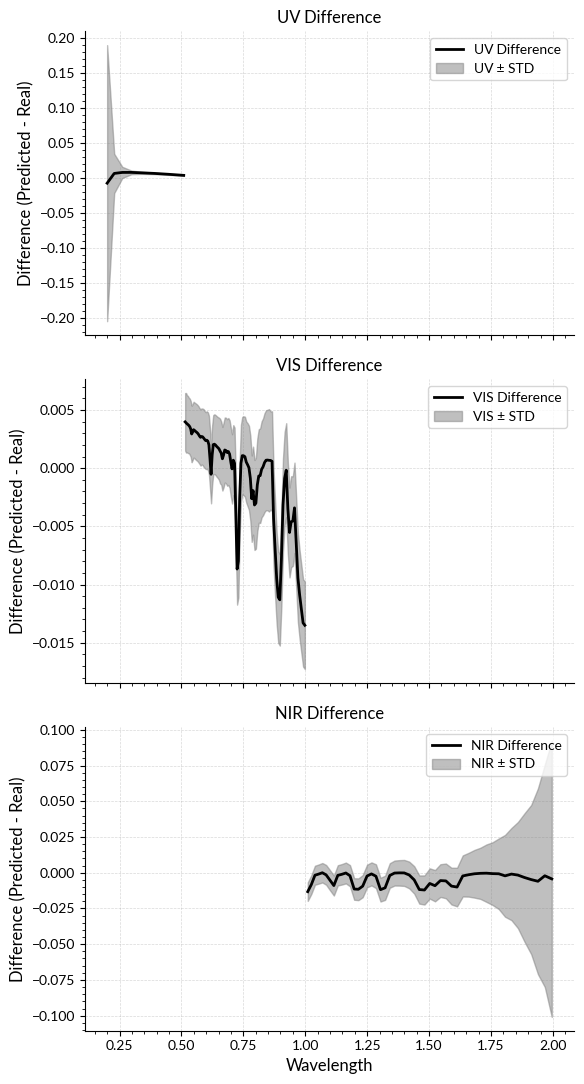

Processing: Modern at 10 pc - LUVOIR-B with stage: modern
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


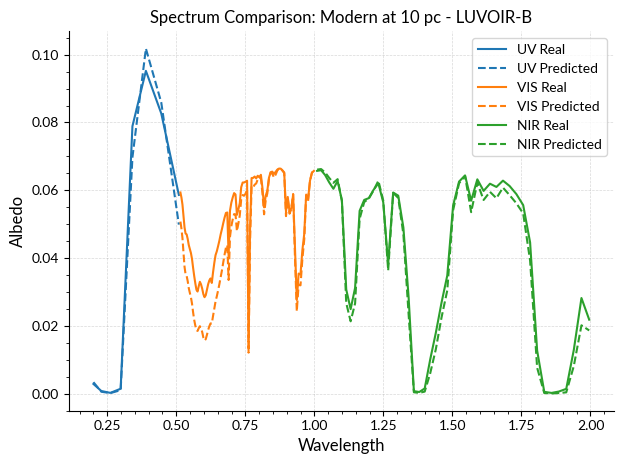

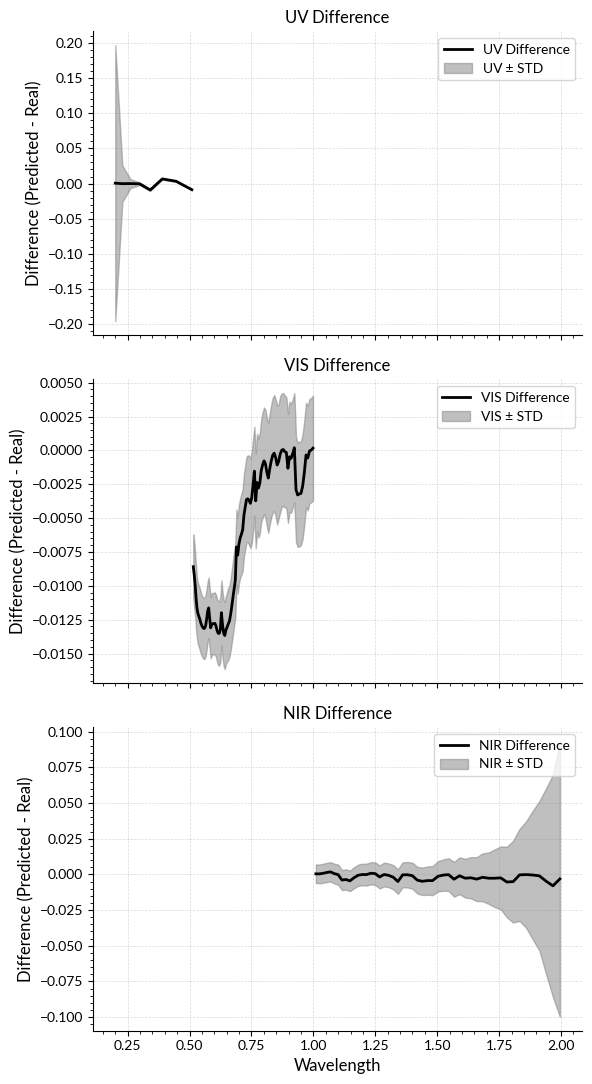

Processing: Proterozoic at 10 pc - LUVOIR-B with stage: proterozoic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


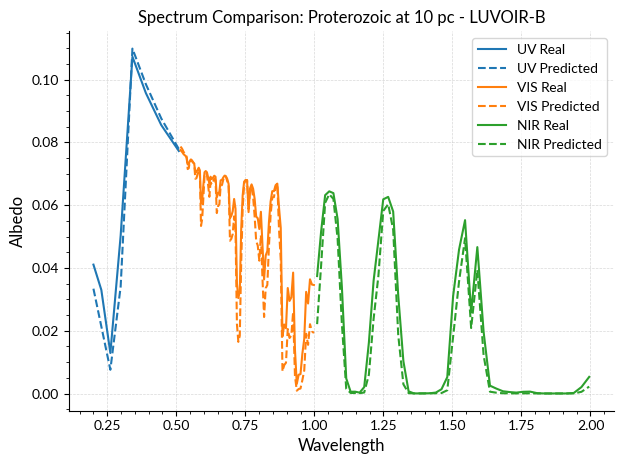

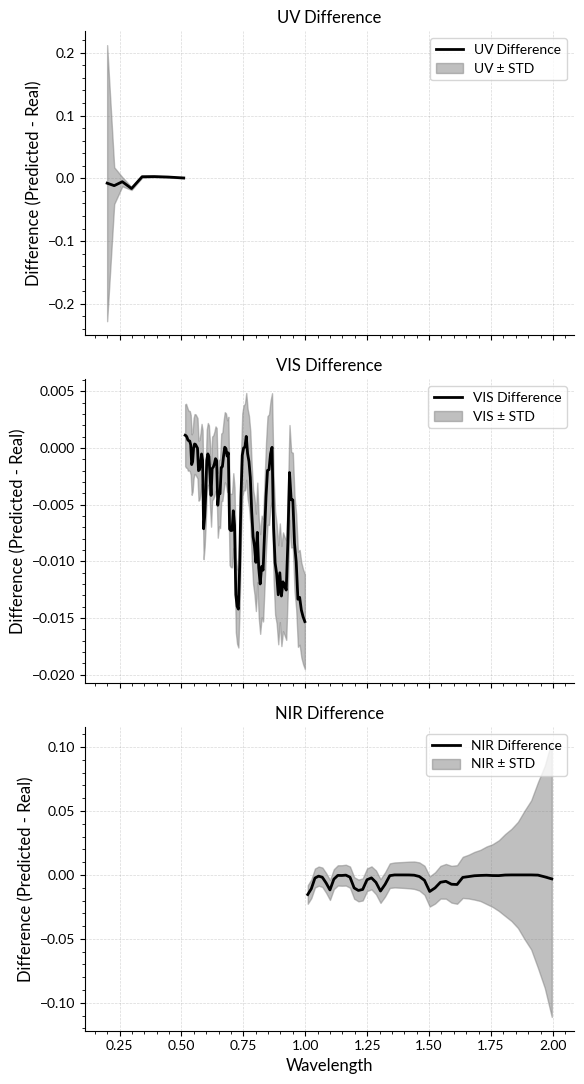

In [ ]:
npy_files = glob.glob("../data/tests/*10pc*luvoir*.npy")
npy_files = [f for f in npy_files if "without" not in os.path.basename(f).lower()]

for file_path in npy_files:
    file_name = os.path.basename(file_path)
    formatted_title = format_title_luvoir(file_name)
    stage = get_stage_from_filename(file_name)
    print("Processing:", formatted_title, "with stage:", stage)
    
    # Load npy file (assumes similar structure as before)
    data = np.load(file_path, allow_pickle=True)
    uv = data[0]["NOISY_ALBEDO"]
    vis = data[1]["NOISY_ALBEDO"]
    nir = data[2]["NOISY_ALBEDO"]
    
    # Normalize each band using loaded stats
    uv_norm = (uv - stats['inputs']['B-UV']['mean']) / stats['inputs']['B-UV']['std']
    vis_norm = (vis - stats['inputs']['B-Vis']['mean']) / stats['inputs']['B-Vis']['std']
    nir_norm = (nir - stats['inputs']['B-NIR']['mean']) / stats['inputs']['B-NIR']['std']
    
    # Reshape to match model input dimensions
    uv_norm = uv_norm.reshape(1, 8, 1)
    vis_norm = vis_norm.reshape(1, 94, 1)
    nir_norm = nir_norm.reshape(1, 49, 1)
    
    # Get predictions from the model using the npy data
    predictions = model_load.predict([uv_norm, vis_norm, nir_norm])
    physical_pred = denormalize_physical(predictions['physical_output'], stats, physical_targets)
    main_chem_pred = denormalize_chemical(predictions['main_chemical_output'], stats, main_chemical_targets)
    other_chem_pred = denormalize_chemical(predictions['other_chemical_output'], stats, other_chemical_targets)
    
    # Extract predicted physical parameters
    predicted_radius      = physical_pred[0, 0] 
    predicted_gravity     = physical_pred[0, 1]
    predicted_temperature = physical_pred[0, 2]
    predicted_pressure    = physical_pred[0, 3]
    
    # Merge chemical predictions into a dictionary.
    predicted_gas_values = {
        "O2": main_chem_pred[0, 0],
        "O3": main_chem_pred[0, 1],
        "CH4": other_chem_pred[0, 0],
        "CO": other_chem_pred[0, 1],
        "CO2": other_chem_pred[0, 2],
        "H2O": other_chem_pred[0, 3],
        "N2": other_chem_pred[0, 4],
        "N2O": other_chem_pred[0, 5]
    }
    
    dg, config = get_config_data(stage)
    uv_real  = generate_original_spectrum(config, "B-UV", dg)
    vis_real = generate_original_spectrum(config, "B-Vis", dg)
    nir_real = generate_original_spectrum(config, "B-NIR", dg)
    
    uv_pred  = generate_modified_spectrum(config, "B-UV", dg,
                                            predicted_radius,
                                            predicted_gravity,
                                            predicted_temperature,
                                            predicted_pressure,
                                            predicted_gas_values)
    vis_pred = generate_modified_spectrum(config, "B-Vis", dg,
                                            predicted_radius,
                                            predicted_gravity,
                                            predicted_temperature,
                                            predicted_pressure,
                                            predicted_gas_values)
    nir_pred = generate_modified_spectrum(config, "B-NIR", dg,
                                            predicted_radius,
                                            predicted_gravity,
                                            predicted_temperature,
                                            predicted_pressure,
                                            predicted_gas_values)

    # UV channel 
    plt.plot(uv_real["WAVELENGTH"], uv_real["ALBEDO"], label="UV Real", color="tab:blue")
    plt.plot(uv_pred["WAVELENGTH"], uv_pred["ALBEDO"], label="UV Predicted", color="tab:blue", linestyle="--")

    # VIS channel
    plt.plot(vis_real["WAVELENGTH"], vis_real["ALBEDO"], label="VIS Real", color="tab:orange")
    plt.plot(vis_pred["WAVELENGTH"], vis_pred["ALBEDO"], label="VIS Predicted", color="tab:orange", linestyle="--")

    # NIR channel 
    plt.plot(nir_real["WAVELENGTH"], nir_real["ALBEDO"], label="NIR Real", color="tab:green")
    plt.plot(nir_pred["WAVELENGTH"], nir_pred["ALBEDO"], label="NIR Predicted", color="tab:green", linestyle="--")

    plt.xlabel("Wavelength")
    plt.ylabel("Albedo")
    plt.title(f"Spectrum Comparison: {formatted_title}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    def plot_difference(ax, wavelength, real_albedo, pred_albedo, real_noise, pred_noise, channel_label):
        diff = pred_albedo - real_albedo
        # Compute the combined uncertainty
        error = np.sqrt(real_noise**2 + pred_noise**2)
        
        ax.plot(wavelength, diff, color='black', linewidth=2, label=f"{channel_label} Difference")
        ax.fill_between(wavelength, diff - error, diff + error, color='gray', alpha=0.5,
                        label=f"{channel_label} ± STD")
        ax.set_ylabel("Difference (Predicted - Real)")
        ax.set_title(f"{channel_label} Difference")
        ax.legend()

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 11), sharex=True)

    plot_difference(axes[0],
                    uv_real["WAVELENGTH"],
                    uv_real["ALBEDO"],
                    uv_pred["ALBEDO"],
                    uv_real["NOISE"],
                    uv_pred["NOISE"],
                    "UV")

    plot_difference(axes[1],
                    vis_real["WAVELENGTH"],
                    vis_real["ALBEDO"],
                    vis_pred["ALBEDO"],
                    vis_real["NOISE"],
                    vis_pred["NOISE"],
                    "VIS")

    plot_difference(axes[2],
                    nir_real["WAVELENGTH"],
                    nir_real["ALBEDO"],
                    nir_pred["ALBEDO"],
                    nir_real["NOISE"],
                    nir_pred["NOISE"],
                    "NIR")

    plt.xlabel("Wavelength")
    plt.tight_layout()
    plt.show()